In [1]:
import numpy as np
import matplotlib.pyplot as plt
import LibraryTimo_PVT
import LibraryTimo_HP
import LibraryTimo_DH
import pandas as pd
from scipy.constants import pi
from math import exp, log


K = 273                 # [K]


In [2]:
T_amb_imp = np.loadtxt('data/Main/Tamb_KNMI_21tm23_Q.csv', delimiter=';') # T ambient in De Bilt from 2021 until 2023, quarterly values (C)
G_imp = np.loadtxt('data/Main/G_DeBilt_21_23_Q.csv', delimiter=';')       # Irradiance quarterly values (W/m^2)
V_imp = np.loadtxt('data/Main/Vwind_DeBilt_21_23_Q.csv', delimiter=';')   # Wind speeds quarterly values (m/s)

Vw = V_imp                                                            # Wind speed (m/s)
G = G_imp                                                            # Irradiance (W/m^2)
T_amb = np.add(T_amb_imp, K)                                         # Ambient termperature (K)

In [3]:
startDay = 0
endDay = 365
ts = (endDay-startDay) * 24 * 4         # Simulation timesteps
dt = 15 * 60                            # Amount of seconds in timesteps

In [4]:
def PVT_precalc(T_amb, G, Vw, T_in, dt):

    PVT_active = True
    dt_pvt = 1
    T_glass = T_in-K
    T_PV = T_in-1-K
    T_a = T_in-K
    T_f = T_in-K
    Tf_out = T_in-K

    for t in range(int(dt/dt_pvt)):

        T_f_in = Tf_out

        [T_glass, T_PV, T_a, T_f, Q] = LibraryTimo_PVT.PVT_model(T_amb-K, G, Vw, T_f_in, T_glass, T_PV, T_a, T_f, dt_pvt, PVT_active) # Output in [C]
    
        Tf_out = (T_f - 0.5*T_f_in)/0.5
    
    return T_f+K

trange = range(ts)

PVT_T_f = [[] for i in trange ]

TinRange = np.arange(10+K, 25+K, 1)

for t in trange:
    for Tin in TinRange:
        T_f_end = PVT_precalc(T_amb[t],G[t],Vw[t],Tin,dt)
        PVT_T_f[t].append(T_f_end)                          # Array with the fluid output temperature of a single PVT panel depending on the incoming DHN temperature


np.savetxt("Data/PVTout_TinRange_10to25.csv", PVT_T_f, delimiter=";")


In [ ]:
PVT_precalc = np.loadtxt('Data/Main/PVTout_TinRange_10to25.csv', delimiter=';') 
# PVT_precalc = PVT_T_f
m_f_dot_PVT=0.029085
c_f = 4200

QdotPVT_PC_array = [[] for i in range(len(PVT_precalc))]
Fluid_out_temp = [[] for i in range(len(PVT_precalc))]


for t in range(len(PVT_precalc)):
# for t in range(1000):
    for i in range(len(PVT_precalc[0])):
        Tin = TinRange[i]
        T_f_end = PVT_precalc[t][i]
        deltaT = T_f_end - Tin
        if deltaT > 0:
            
            Qdot_pvt = 2 * 0.9 * m_f_dot_PVT * c_f * deltaT
            fluid = T_f_end
            
        
        else:
            
            Qdot_pvt = 0
            fluid = Tin

        Fluid_out_temp[t].append(fluid)
        QdotPVT_PC_array[t].append(Qdot_pvt)        # Array with QdotPVT per timestep depending on the incoming DHN temperature



# np.savetxt("Data/QdotPVT_PC_array_10to25.csv", QdotPVT_PC_array, delimiter=";")
# np.savetxt("Data/PVT_fluid_temp_10to25.csv", Fluid_out_temp, delimiter=";")

In [7]:
Qdot_PVT_PC = np.loadtxt('data/QdotPVT_PC_array_10to25.csv', delimiter=';')
# Qdot_PVT_PC = QdotPVT_PC_array
output = []
K = 273
# Replace these with your actual data
for i in range(len(Qdot_PVT_PC)):
# for i in range(1):
    Y = Qdot_PVT_PC[i]


    mask_active = Y > 0
    X_active = TinRange[mask_active]
    Y_active = Y[mask_active]

    # Inactive (zeros or low)
    X_inactive = TinRange[~mask_active]
    Y_inactive = Y[~mask_active]
    

    if len(X_active) != 0 and len(Y_active) != 0:
        if len(X_active) == 1 and len(Y_active) == 1:
            # Perform linear regression
            coefficients = np.polyfit(TinRange[0:2], Y[0:2], 1)  # 1 means linear fit (degree=1)
            slope, intercept = coefficients
            Y_pred = slope * TinRange[0:2] + intercept
            # Compute R²
            ss_res = np.sum((Y[0:2] - Y_pred) ** 2)             # Residual sum of squares
            ss_tot = np.sum((Y[0:2] - np.mean(Y[0:2])) ** 2)         # Total sum of squares
            # Compute R² with zero-variance handling
            if np.isclose(ss_tot, 0):
                r_squared = np.nan  # or 0.0 if you prefer a defined number
            else:
                r_squared = 1 - (ss_res / ss_tot)

        
            x_intercept = -intercept / slope
            
        else:
            # Perform linear regression
            coefficients = np.polyfit(X_active, Y_active, 1)  # 1 means linear fit (degree=1)
            slope, intercept = coefficients
            Y_pred = slope * X_active + intercept

    


            # Compute R²
            ss_res = np.sum((Y_active - Y_pred) ** 2)             # Residual sum of squares
            ss_tot = np.sum((Y_active - np.mean(Y_active)) ** 2)         # Total sum of squares
            # Compute R² with zero-variance handling
            if np.isclose(ss_tot, 0):
                r_squared = np.nan  # or 0.0 if you prefer a defined number
            else:
                r_squared = 1 - (ss_res / ss_tot)

        
            x_intercept = -intercept / slope

        if len(X_inactive) != 0 and len(Y_inactive) != 0:
            output.append([slope, intercept, r_squared, True, x_intercept])        
        else:
            output.append([slope, intercept, r_squared, False, 0])
   
    else:
        output.append([0, 0, 0, 0, 0])



np.savetxt("data/QdotTrends_10to25.csv", output, delimiter=";")


2930 0.9845226095826131
2932 0.9848282375005187
3792 0.9896959516608447
3793 0.9890389564439295
3880 0.9769666250963818
3881 0.9796917589278862
3882 0.9829017208757465
3883 0.9864210609507009
3885 0.9817533429269333
3889 0.9811863922484221
3890 0.9777662281006455
3974 0.9819787358044796
3977 0.9894243721558138
3987 0.9877683901592185
3989 0.9812130373624627
4168 0.9846684009533735
4169 0.9879432340457893
4179 0.9890966042285568
4181 0.9876559908007385
8771 0.9863920971445422
9149 0.9709274944972299
9150 0.9886844679907697
9728 0.9762133281834936
9731 0.9789369567761936
9758 0.9891513982727158
32679 0.9878383081564208
32683 0.987539613017049


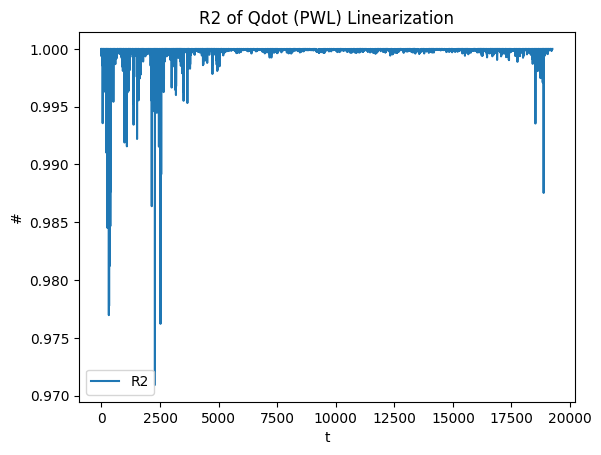

In [8]:
# Qdot_PVT_Trends = np.loadtxt("data/QdotTrends.csv", delimiter=";")
Qdot_PVT_Trends = output

R2out = []

for t in range(len(Qdot_PVT_Trends)):
    R2 = Qdot_PVT_Trends[t][2]
    if R2 != 0:
        if R2 <= 0.99:
            print(t, R2)
        R2out.append(R2)

plt.figure(3)
plt.plot(R2out, label="R2")
plt.title("R2 of Qdot (PWL) Linearization")
plt.xlabel("t")
plt.ylabel("#")
plt.legend()
plt.show()
